In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns



In [2]:
dir= "C:\\Study\\1014\\1014\\NFL_Analysis\\"

In [3]:
con =sqlite3.connect(dir+"nfl_2024.db")

sql_command = """

select a.*, case when club=possessionTeam then 'attack' else 'def' end as attack 
from
(select gameId,playId, frameId, case when nflId is null then 99999 else nflId end as nflId,club,playDirection, x,y,s,a,dir,o,dis from tracking_data) A
inner JOIN
(
select gameId,playId, min(frameId) as frameId from tracking_data
where event in ('ball_snap','autoevent_ballsnap','man_in_motion')
group by gameId, PlayId
--having min(frameId) >10
)B
on A.gameId=b.gameId
and a.playId=b.playId
and a.frameId>=b.frameId
and a.frameId<=b.frameId+1
inner join plays c
on A.gameId=c.gameId
and a.playId=c.playId


"""
td=pd.read_sql_query(sql_command,con)
con.close()
td.shape

(291416, 14)

In [4]:
td.head()

,gameId,playId,frameId,nflId,club,playDirection,x,y,s,a,dir,o,dis,attack
0,2022090800,101,6,35472,BUF,left,73.13,27.67,0.10,1.14,348.75,273.97,0.02,attack
1,2022090800,101,7,35472,BUF,left,73.11,27.71,0.42,2.43,346.58,272.30,0.04,attack
2,2022090800,101,6,38577,LA,left,67.35,29.96,0.07,0.06,26.33,70.42,0.04,def
3,2022090800,101,7,38577,LA,left,67.34,29.99,0.08,0.07,14.73,68.16,0.03,def
4,2022090800,101,6,41239,LA,left,71.30,26.43,0.02,0.03,95.37,64.49,0.01,def


In [5]:
td['order']=td.groupby(['gameId','playId','nflId'])['frameId'].rank('first').apply(int)

td_start=td[['gameId', 'playId','nflId','attack' ,'x', 'y', 's', 'a', 'dir', 'o', 'dis','order']]

td_start['order']=td_start['order'].apply(str).str.zfill(2)
ball_coordinates=td_start[(td_start.order=='01')&(td_start.nflId==99999)][['gameId', 'playId','nflId','x', 'y']]
ball_coordinates.head()

C:\study_tools\envs\DL\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,gameId,playId,nflId,x,y
44,2022090800,101,99999,72.040001,29.520000
90,2022090800,146,99999,61.820000,29.690001
136,2022090800,191,99999,45.060001,23.629999
182,2022090800,299,99999,26.700001,23.670000
228,2022090800,343,99999,26.690001,29.459999


In [6]:
td_start= td_start.pivot_table(index=['gameId','playId','nflId','attack'],columns=['order'],values=[ 'x', 'y', 's', 'a', 'dir', 'o', 'dis'],aggfunc='first')

td_start.columns = ['_lag_'.join(col) for col in td_start.columns.values]
td_start=td_start.reset_index()
td_start.head()

,gameId,playId,nflId,attack,a_lag_01,a_lag_02,dir_lag_01,dir_lag_02,dis_lag_01,dis_lag_02,o_lag_01,o_lag_02,s_lag_01,s_lag_02,x_lag_01,x_lag_02,y_lag_01,y_lag_02
0,2022090800,101,35472,attack,1.14,2.43,348.75,346.58,0.02,0.04,273.97,272.30,0.10,0.42,73.13,73.11,27.67,27.71
1,2022090800,101,38577,def,0.06,0.07,26.33,14.73,0.04,0.03,70.42,68.16,0.07,0.08,67.35,67.34,29.96,29.99
2,2022090800,101,41239,def,0.03,0.33,95.37,71.22,0.01,0.01,64.49,77.85,0.02,0.03,71.30,71.31,26.43,26.43
3,2022090800,101,42392,attack,0.08,0.96,224.11,341.23,0.00,0.02,273.23,274.48,0.00,0.10,72.50,72.49,29.47,29.49
4,2022090800,101,42816,def,0.23,0.10,0.54,353.61,0.04,0.06,100.21,97.66,0.43,0.49,64.66,64.65,40.90,40.95


In [7]:
ball_coordinates.shape,ball_coordinates[['gameId','playId']].drop_duplicates().shape

((6338, 5), (6338, 2))

In [8]:
td_start=td_start.merge(ball_coordinates,how='inner',on=['gameId','playId'])
td_start['distance']= np.sqrt(((td_start.x-td_start.x_lag_01)**2)+((td_start.y-td_start.y_lag_01)**2))
td_start.head()

,gameId,playId,nflId_x,attack,a_lag_01,a_lag_02,dir_lag_01,dir_lag_02,dis_lag_01,dis_lag_02,...,s_lag_01,s_lag_02,x_lag_01,x_lag_02,y_lag_01,y_lag_02,nflId_y,x,y,distance
0,2022090800,101,35472,attack,1.14,2.43,348.75,346.58,0.02,0.04,...,0.10,0.42,73.13,73.11,27.67,27.71,99999,72.040001,29.52,2.147231
1,2022090800,101,38577,def,0.06,0.07,26.33,14.73,0.04,0.03,...,0.07,0.08,67.35,67.34,29.96,29.99,99999,72.040001,29.52,4.710595
2,2022090800,101,41239,def,0.03,0.33,95.37,71.22,0.01,0.01,...,0.02,0.03,71.30,71.31,26.43,26.43,99999,72.040001,29.52,3.177374
3,2022090800,101,42392,attack,0.08,0.96,224.11,341.23,0.00,0.02,...,0.00,0.10,72.50,72.49,29.47,29.49,99999,72.040001,29.52,0.462709
4,2022090800,101,42816,def,0.23,0.10,0.54,353.61,0.04,0.06,...,0.43,0.49,64.66,64.65,40.90,40.95,99999,72.040001,29.52,13.563510


In [9]:
td_start.columns.tolist()

['gameId',
 'playId',
 'nflId_x',
 'attack',
 'a_lag_01',
 'a_lag_02',
 'dir_lag_01',
 'dir_lag_02',
 'dis_lag_01',
 'dis_lag_02',
 'o_lag_01',
 'o_lag_02',
 's_lag_01',
 's_lag_02',
 'x_lag_01',
 'x_lag_02',
 'y_lag_01',
 'y_lag_02',
 'nflId_y',
 'x',
 'y',
 'distance']

In [10]:
q_vars=['a_lag_01',
 'a_lag_02',
 'dir_lag_01',
 'dir_lag_02',
 'dis_lag_01',
 'dis_lag_02',
 'o_lag_01',
 'o_lag_02',
 's_lag_01',
 's_lag_02',
 'x_lag_01',
 'x_lag_02',
 'y_lag_01',
 'y_lag_02']

In [11]:
n_players=10
td_start['order']=td_start.groupby(['gameId','playId','attack'])['distance'].rank('min').apply(int)
td_start=td_start[td_start.order<=n_players]
td_start['order']=td_start['order'].apply(str).str.zfill(2)

td_start= td_start.pivot_table(index=['gameId','playId','attack'],columns=['order'],values=q_vars,aggfunc='first')
td_start.columns = ['_p2b_dis_'.join(col) for col in td_start.columns.values]
td_start=td_start.reset_index()
td_start.head()


,gameId,playId,attack,a_lag_01_p2b_dis_01,a_lag_01_p2b_dis_02,a_lag_01_p2b_dis_03,a_lag_01_p2b_dis_04,a_lag_01_p2b_dis_05,a_lag_01_p2b_dis_06,a_lag_01_p2b_dis_07,...,y_lag_02_p2b_dis_01,y_lag_02_p2b_dis_02,y_lag_02_p2b_dis_03,y_lag_02_p2b_dis_04,y_lag_02_p2b_dis_05,y_lag_02_p2b_dis_06,y_lag_02_p2b_dis_07,y_lag_02_p2b_dis_08,y_lag_02_p2b_dis_09,y_lag_02_p2b_dis_10
0,2022090800,101,attack,0.08,0.00,0.00,1.14,0.00,0.00,3.19,...,29.490000,29.57,31.24,27.71,32.80,26.05,26.78,34.57,29.56,20.38
1,2022090800,101,def,0.29,0.04,0.01,0.03,0.06,0.64,0.02,...,29.510000,29.04,31.77,26.43,29.99,24.55,35.94,23.06,19.30,34.72
2,2022090800,146,attack,0.19,0.00,0.38,0.66,0.04,0.68,0.17,...,31.040000,29.55,29.51,27.81,31.73,32.47,26.20,34.26,23.69,38.48
3,2022090800,146,def,0.06,0.95,0.12,0.81,0.07,0.06,0.07,...,29.690001,29.65,32.27,26.82,23.91,35.64,28.03,21.86,34.35,40.78
4,2022090800,191,attack,1.83,2.09,1.34,2.00,1.15,1.85,0.01,...,23.680000,23.72,25.15,22.01,26.76,20.50,28.37,29.77,23.62,34.83


In [12]:
pivot_list = [e for e in td_start.columns.to_list() if e not in ('gameId', 'playId','attack')]

In [13]:
td_start= td_start.pivot_table(index=['gameId','playId'],columns=['attack'],values=pivot_list,aggfunc='first')
td_start.columns = ['_'.join(col) for col in td_start.columns.values]
td_start=td_start.reset_index()
td_start.head()

,gameId,playId,a_lag_01_p2b_dis_01_attack,a_lag_01_p2b_dis_01_def,a_lag_01_p2b_dis_02_attack,a_lag_01_p2b_dis_02_def,a_lag_01_p2b_dis_03_attack,a_lag_01_p2b_dis_03_def,a_lag_01_p2b_dis_04_attack,a_lag_01_p2b_dis_04_def,...,y_lag_02_p2b_dis_06_attack,y_lag_02_p2b_dis_06_def,y_lag_02_p2b_dis_07_attack,y_lag_02_p2b_dis_07_def,y_lag_02_p2b_dis_08_attack,y_lag_02_p2b_dis_08_def,y_lag_02_p2b_dis_09_attack,y_lag_02_p2b_dis_09_def,y_lag_02_p2b_dis_10_attack,y_lag_02_p2b_dis_10_def
0,2022090800,101,0.08,0.29,0.00,0.04,0.00,0.01,1.14,0.03,...,26.05,24.55,26.78,35.94,34.57,23.06,29.56,19.30,20.38,34.72
1,2022090800,146,0.19,0.06,0.00,0.95,0.38,0.12,0.66,0.81,...,32.47,35.64,26.20,28.03,34.26,21.86,23.69,34.35,38.48,40.78
2,2022090800,191,1.83,0.00,2.09,1.05,1.34,0.12,2.00,0.93,...,20.50,18.28,28.37,30.58,29.77,31.99,23.62,35.27,34.83,20.18
3,2022090800,299,1.73,0.00,1.07,0.50,0.90,0.99,0.72,0.34,...,27.04,28.32,19.02,21.44,20.17,28.93,28.96,15.37,23.74,33.28
4,2022090800,343,0.65,0.00,0.90,0.89,0.24,0.09,0.44,0.99,...,33.83,35.17,29.73,35.16,27.51,22.60,21.44,38.86,38.58,34.52


In [14]:
con =sqlite3.connect(dir+"nfl_2024.db")

sql_command = """
select gameId,playId, ballCarrierId,position as position_rec from
plays A
inner JOIN
players B
on A.ballCarrierId=B.nflId

"""
rec_end=pd.read_sql_query(sql_command,con)
con.close()

In [15]:
rec_end.head()

,gameId,playId,ballCarrierId,position_rec
0,2022100908,3537,48723,TE
1,2022091103,3126,52457,WR
2,2022091111,1148,42547,TE
3,2022100212,2007,46461,RB
4,2022091900,1372,47857,RB


In [16]:
rec_end.shape,td.shape,td_start.shape

((12486, 4), (291416, 15), (6338, 282))

In [17]:
inputdata_target= rec_end.pivot_table(index=['gameId','playId'], columns='position_rec', values=['ballCarrierId'],aggfunc='count')
inputdata_target.columns = ['_'.join(col) for col in inputdata_target.columns.values]
inputdata_target=inputdata_target.reset_index()
inputdata_target.fillna(0,inplace=True)
inputdata_target.head()

,gameId,playId,ballCarrierId_FB,ballCarrierId_QB,ballCarrierId_RB,ballCarrierId_TE,ballCarrierId_WR
0,2022090800,56,0.0,0.0,0.0,0.0,1.0
1,2022090800,80,0.0,1.0,0.0,0.0,0.0
2,2022090800,101,0.0,0.0,1.0,0.0,0.0
3,2022090800,122,0.0,0.0,1.0,0.0,0.0
4,2022090800,146,0.0,0.0,1.0,0.0,0.0


In [18]:
target_cols=['ballCarrierId_FB','ballCarrierId_QB','ballCarrierId_RB','ballCarrierId_TE','ballCarrierId_WR']

In [19]:
inputdata_target.sum().apply(int)

gameId              25247927537841
playId                    24804731
ballCarrierId_FB                62
ballCarrierId_QB               875
ballCarrierId_RB              6919
ballCarrierId_TE              1292
ballCarrierId_WR              3338
dtype: int64

In [20]:
inputdata= td_start.copy(deep=True)  

inputdata.shape

(6338, 282)

In [21]:
inputdata['key']=inputdata.gameId.astype(str)+inputdata.playId.astype(str)
inputdata_target['key']= inputdata_target.gameId.astype(str)+inputdata_target.playId.astype(str)


In [22]:
gnn_cols= [e for e in inputdata.columns.to_list() if e not in ('gameId', 'playId','attack','key')]
gnn_cols

['a_lag_01_p2b_dis_01_attack',
 'a_lag_01_p2b_dis_01_def',
 'a_lag_01_p2b_dis_02_attack',
 'a_lag_01_p2b_dis_02_def',
 'a_lag_01_p2b_dis_03_attack',
 'a_lag_01_p2b_dis_03_def',
 'a_lag_01_p2b_dis_04_attack',
 'a_lag_01_p2b_dis_04_def',
 'a_lag_01_p2b_dis_05_attack',
 'a_lag_01_p2b_dis_05_def',
 'a_lag_01_p2b_dis_06_attack',
 'a_lag_01_p2b_dis_06_def',
 'a_lag_01_p2b_dis_07_attack',
 'a_lag_01_p2b_dis_07_def',
 'a_lag_01_p2b_dis_08_attack',
 'a_lag_01_p2b_dis_08_def',
 'a_lag_01_p2b_dis_09_attack',
 'a_lag_01_p2b_dis_09_def',
 'a_lag_01_p2b_dis_10_attack',
 'a_lag_01_p2b_dis_10_def',
 'a_lag_02_p2b_dis_01_attack',
 'a_lag_02_p2b_dis_01_def',
 'a_lag_02_p2b_dis_02_attack',
 'a_lag_02_p2b_dis_02_def',
 'a_lag_02_p2b_dis_03_attack',
 'a_lag_02_p2b_dis_03_def',
 'a_lag_02_p2b_dis_04_attack',
 'a_lag_02_p2b_dis_04_def',
 'a_lag_02_p2b_dis_05_attack',
 'a_lag_02_p2b_dis_05_def',
 'a_lag_02_p2b_dis_06_attack',
 'a_lag_02_p2b_dis_06_def',
 'a_lag_02_p2b_dis_07_attack',
 'a_lag_02_p2b_dis_07_def

In [23]:
X=inputdata.merge(inputdata_target,on=['key'],how='inner')
X.shape

(6338, 290)

In [24]:
X.loc[:,X.columns.str.contains('x_lag.*def')].columns.tolist()

['x_lag_01_p2b_dis_01_def',
 'x_lag_01_p2b_dis_02_def',
 'x_lag_01_p2b_dis_03_def',
 'x_lag_01_p2b_dis_04_def',
 'x_lag_01_p2b_dis_05_def',
 'x_lag_01_p2b_dis_06_def',
 'x_lag_01_p2b_dis_07_def',
 'x_lag_01_p2b_dis_08_def',
 'x_lag_01_p2b_dis_09_def',
 'x_lag_01_p2b_dis_10_def',
 'x_lag_02_p2b_dis_01_def',
 'x_lag_02_p2b_dis_02_def',
 'x_lag_02_p2b_dis_03_def',
 'x_lag_02_p2b_dis_04_def',
 'x_lag_02_p2b_dis_05_def',
 'x_lag_02_p2b_dis_06_def',
 'x_lag_02_p2b_dis_07_def',
 'x_lag_02_p2b_dis_08_def',
 'x_lag_02_p2b_dis_09_def',
 'x_lag_02_p2b_dis_10_def']

In [25]:
xy_positions=[ 'x_lag_01_p2b_dis_01_def', 'y_lag_01_p2b_dis_01_def',
 'x_lag_01_p2b_dis_02_def','y_lag_01_p2b_dis_02_def',
 'x_lag_01_p2b_dis_03_def','y_lag_01_p2b_dis_03_def',
 'x_lag_01_p2b_dis_04_def','y_lag_01_p2b_dis_04_def',
 'x_lag_01_p2b_dis_05_def','y_lag_01_p2b_dis_05_def',
 'x_lag_01_p2b_dis_06_def','y_lag_01_p2b_dis_06_def',
 'x_lag_01_p2b_dis_07_def','y_lag_01_p2b_dis_07_def',
 'x_lag_01_p2b_dis_08_def','y_lag_01_p2b_dis_08_def',
 'x_lag_01_p2b_dis_09_def','y_lag_01_p2b_dis_09_def',
 'x_lag_01_p2b_dis_10_def','y_lag_01_p2b_dis_10_def',
 'x_lag_01_p2b_dis_01_attack','y_lag_01_p2b_dis_01_attack',
 'x_lag_01_p2b_dis_02_attack','y_lag_01_p2b_dis_02_attack',
 'x_lag_01_p2b_dis_03_attack','y_lag_01_p2b_dis_03_attack',
 'x_lag_01_p2b_dis_04_attack','y_lag_01_p2b_dis_04_attack',
 'x_lag_01_p2b_dis_05_attack','y_lag_01_p2b_dis_05_attack',
 'x_lag_01_p2b_dis_06_attack','y_lag_01_p2b_dis_06_attack',
 'x_lag_01_p2b_dis_07_attack','y_lag_01_p2b_dis_07_attack',
 'x_lag_01_p2b_dis_08_attack','y_lag_01_p2b_dis_08_attack',
 'x_lag_01_p2b_dis_09_attack','y_lag_01_p2b_dis_09_attack',
 'x_lag_01_p2b_dis_10_attack','y_lag_01_p2b_dis_10_attack'
]

positions=X[xy_positions].values



In [26]:
con =sqlite3.connect(dir+"nfl_2024.db")

sql_command = """
select
a.gameId,a.playId,quarter,down,yardsToGo,preSnapHomeScore,preSnapVisitorScore,playResult,absoluteYardlineNumber,defendersInTheBox,
gameClock,yardlineSide,offenseFormation
from 
plays a
inner join games  b 
on a.gameid=b.gameid
    """
play=pd.read_sql_query(sql_command,con)
con.close()

In [27]:
play['gameClock']= (max(pd.to_datetime(play['gameClock'])) - pd.to_datetime(play['gameClock'])).astype('timedelta64[ms]')/10000

In [28]:
play['key']= play.gameId.astype(str)+play.playId.astype(str)

In [29]:
play_cols=['gameClock',
 'yardsToGo',
 'preSnapHomeScore',
 'preSnapVisitorScore',
 'playResult',
 'absoluteYardlineNumber',
 'defendersInTheBox']

In [30]:
#categorical data
categorical_cols = ['quarter',
 'down',
 'yardlineSide',
 'offenseFormation'
 
 ] 


play=pd.get_dummies(play, columns = categorical_cols)

In [31]:
play.columns.tolist()

['gameId',
 'playId',
 'yardsToGo',
 'preSnapHomeScore',
 'preSnapVisitorScore',
 'playResult',
 'absoluteYardlineNumber',
 'defendersInTheBox',
 'gameClock',
 'key',
 'quarter_1',
 'quarter_2',
 'quarter_3',
 'quarter_4',
 'quarter_5',
 'down_1',
 'down_2',
 'down_3',
 'down_4',
 'yardlineSide_ARI',
 'yardlineSide_ATL',
 'yardlineSide_BAL',
 'yardlineSide_BUF',
 'yardlineSide_CAR',
 'yardlineSide_CHI',
 'yardlineSide_CIN',
 'yardlineSide_CLE',
 'yardlineSide_DAL',
 'yardlineSide_DEN',
 'yardlineSide_DET',
 'yardlineSide_GB',
 'yardlineSide_HOU',
 'yardlineSide_IND',
 'yardlineSide_JAX',
 'yardlineSide_KC',
 'yardlineSide_LA',
 'yardlineSide_LAC',
 'yardlineSide_LV',
 'yardlineSide_MIA',
 'yardlineSide_MIN',
 'yardlineSide_NE',
 'yardlineSide_NO',
 'yardlineSide_NYG',
 'yardlineSide_NYJ',
 'yardlineSide_PHI',
 'yardlineSide_PIT',
 'yardlineSide_SEA',
 'yardlineSide_SF',
 'yardlineSide_TB',
 'yardlineSide_TEN',
 'yardlineSide_WAS',
 'offenseFormation_EMPTY',
 'offenseFormation_I_FORM',


In [32]:
play_col_list = [e for e in play.columns.to_list() if e not in ('gameId', 'playId','key')]

In [33]:
X=X.merge(play,on=['key'],how='inner')

In [34]:
X[gnn_cols].shape,X[target_cols].shape

((6338, 280), (6338, 5))

In [35]:
# Load example data
#features_df = pd.DataFrame(np.random.rand(1000, 100))
#labels_df = pd.DataFrame(np.random.randint(0, 2, (1000, 6)))
#positions_df = pd.DataFrame(np.random.rand(1000, 80))
#

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


features_df=  X[gnn_cols]
features_df.fillna(0,inplace=True)
features_df[gnn_cols]= scaler.fit_transform(features_df[gnn_cols])

labels_df = X[target_cols]
labels_df.fillna(0,inplace=True)

positions_df= X[xy_positions]
positions_df.fillna(0,inplace=True)
#positions_df[xy_positions]=scaler.fit_transform(positions_df[xy_positions])

play_features_df=X[play_col_list]
play_features_df.fillna(0,inplace=True)
play_features_df[play_cols]= scaler.fit_transform(play_features_df[play_cols])



num_players = n_players*2 #both in defense and attack
features_per_player = features_df.shape[1] // num_players
positions_per_player = positions_df.shape[1] // num_players



C:\study_tools\envs\DL\lib\site-packages\pandas\core\frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
C:\study_tools\envs\DL\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
C:\study_tools\envs\DL\lib\site-packages\pandas\core\frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

In [36]:
labels_df.sum(axis=0)

ballCarrierId_FB      16.0
ballCarrierId_QB     399.0
ballCarrierId_RB    5649.0
ballCarrierId_TE      45.0
ballCarrierId_WR     229.0
dtype: float64

In [37]:
5646/labels_df.sum(axis=0).sum()   ## This is the minimun Naive accuracy we can expect

0.8908172925213

In [38]:
num_players,features_per_player,positions_per_player

(20, 14, 2)

In [39]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
import pandas as pd
import numpy as np
from itertools import combinations

C:\study_tools\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
# Function to create edge index and edge attributes based on distances
def create_edge_index_and_attrs(num_players, player_positions):
    edge_index = []
    edge_attr = []
    distances = []

    for (i, j) in combinations(range(num_players), 2):
        distance = np.linalg.norm(np.array(player_positions[i]) - np.array(player_positions[j]))
        distances.append(distance)
        edge_index.append([i, j])
        edge_index.append([j, i])
        edge_attr.append([distance])
        edge_attr.append([distance])

    # Normalize the distances
    scaler = MinMaxScaler()
    edge_attr = scaler.fit_transform(np.array(edge_attr).reshape(-1, 1))

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    return edge_index, edge_attr

# Function to create GNN model
def create_gnn_model(input_dim, output_dim):
    class GNNModel(torch.nn.Module):
        def __init__(self, input_dim, output_dim):
            super(GNNModel, self).__init__()
            self.conv1 = GCNConv(input_dim, 16)
            self.conv2 = GCNConv(16, 16)
            self.fc = torch.nn.Linear(16, output_dim)
            self.dropout = torch.nn.Dropout(p=0.5)

        def forward(self, data):
            x, edge_index, batch = data.x, data.edge_index, data.batch
            x = F.relu(self.conv1(x, edge_index))
            x = self.dropout(x)
            x = F.relu(self.conv2(x, edge_index))
            x = global_mean_pool(x, batch)  # Global mean pool
            x = self.fc(x)
            return x
    
    return GNNModel(input_dim, output_dim)

# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_val_loss = float('inf')
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss, model, epoch):
        if val_loss < self.best_val_loss - self.min_delta:
            self.best_val_loss = val_loss
            self.epochs_no_improve = 0
            torch.save(model.state_dict(), f"model/gnn_model_best_epoch_{epoch + 1}.pth")
        else:
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                self.early_stop = True
        return self.early_stop

In [41]:
# Calculate class weights
class_counts = labels_df.sum(axis=0)
total_counts = len(labels_df)
class_weights = total_counts / (len(class_counts) * class_counts)
class_weights = torch.tensor(class_weights.values, dtype=torch.float)


In [42]:
# Create Data objects for each game
data_list = []
for i in range(len(features_df)):
    game_features = features_df.iloc[i].values.reshape(num_players, features_per_player)
    player_positions = positions_df.iloc[i].values.reshape(num_players, 2).tolist()
    game_labels = labels_df.iloc[i].values
    
    x = torch.tensor(game_features, dtype=torch.float)
    y = torch.tensor(game_labels, dtype=torch.float)  # Change dtype to float for BCEWithLogitsLoss
    
    play_features = play_features_df.iloc[i].values  # Extract play-level features for the current game
    play_features_tensor = torch.tensor(play_features, dtype=torch.float).unsqueeze(0)  # Convert to tensor and add batch dimension


    edge_index, edge_attr = create_edge_index_and_attrs(num_players, player_positions)
    batch = torch.zeros(num_players, dtype=torch.long) + i  # Create batch tensor
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y, batch=batch, play_features=play_features_tensor)
    data_list.append(data)

# DataLoader
loader = DataLoader(data_list, batch_size=1)  # Set batch_size to 1 for proper handling

# Split data into training and validation sets
train_size = int(0.8 * len(data_list))
train_dataset, val_dataset = data_list[:train_size], data_list[train_size:]
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Create model
input_dim = features_per_player  # Number of features per player
output_dim = labels_df.shape[1]  # Number of classes

model = create_gnn_model(input_dim, output_dim)

# Model, optimizer, and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights)


C:\study_tools\envs\DL\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [43]:
def create_gnn_model(input_dim, play_features_dim, output_dim):
    class GNNModel(torch.nn.Module):
        def __init__(self, input_dim, play_features_dim, output_dim):
            super(GNNModel, self).__init__()
            self.play_features_dim = play_features_dim
            self.conv1 = GCNConv(input_dim + play_features_dim, 16)
            self.conv2 = GCNConv(16, 16)
            self.fc = torch.nn.Linear(16, output_dim)
            self.dropout = torch.nn.Dropout(p=0.5)

        def forward(self, data):
            x, edge_index, batch = data.x, data.edge_index, data.batch
            play_features = data.play_features  # Get play-level features

            # Repeat play-level features for each node
            play_features_repeated = play_features.repeat(x.size(0), 1)
            x = torch.cat([x, play_features_repeated], dim=1)  # Concatenate play-level features to node features

            x = F.relu(self.conv1(x, edge_index))
            x = self.dropout(x)
            x = F.relu(self.conv2(x, edge_index))
            x = global_mean_pool(x, batch)  # Global mean pool
            x = self.fc(x)
            return x

    return GNNModel(input_dim, play_features_dim, output_dim)

input_dim = features_per_player  # Number of features per player
play_features_dim = play_features_df.shape[1]  # Number of play-level features
output_dim = labels_df.shape[1]  # Number of classes

model = create_gnn_model(input_dim, play_features_dim, output_dim)


In [44]:
play_features_dim

55

In [45]:
# Model, optimizer, and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights)

# Initialize Early Stopping
early_stopping = EarlyStopping(patience=10, min_delta=0.001)

In [46]:
# Training loop with progress printing and early stopping
train_losses = []
val_losses = []

for epoch in range(100):
    model.train()
    total_train_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        target = data.y.view(out.size(0), -1)  # Reshape the target tensor
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            out = model(data)
            target = data.y.view(out.size(0), -1)  # Reshape the target tensor
            loss = criterion(out, target)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')

    # Early stopping
    if early_stopping(avg_val_loss, model, epoch):
        print("Early stopping")
        break

    # Save the model every 20 epochs
    if (epoch + 1) % 20 == 0:
        torch.save(model.state_dict(), f"model/gnn_model_epoch_{epoch + 1}.pth")

# Save the final model
torch.save(model.state_dict(), "model/gnn_model_final.pth")

Epoch 1, Train Loss: 0.5254533584301289, Val Loss: 0.4682552160677568
Epoch 2, Train Loss: 0.4485502100812319, Val Loss: 0.4605355636049238
Epoch 3, Train Loss: 0.43706775402587783, Val Loss: 0.45460900966348333
Epoch 4, Train Loss: 0.42321601871775805, Val Loss: 0.44414999890684703
Epoch 5, Train Loss: 0.413570007022022, Val Loss: 0.43286757656499414
Epoch 6, Train Loss: 0.3982267061737045, Val Loss: 0.4243933917037931
Epoch 7, Train Loss: 0.3865047765855312, Val Loss: 0.41448707851854505
Epoch 8, Train Loss: 0.372905921515746, Val Loss: 0.40671522866006155
Epoch 9, Train Loss: 0.3639674419985397, Val Loss: 0.39925568051671473
Epoch 10, Train Loss: 0.35616243907178824, Val Loss: 0.3915976219948628
Epoch 11, Train Loss: 0.34684923164311365, Val Loss: 0.38595088993490023
Epoch 12, Train Loss: 0.3428365556056624, Val Loss: 0.3817781373411887
Epoch 13, Train Loss: 0.33891866307786467, Val Loss: 0.3791067589967503
Epoch 14, Train Loss: 0.33247696936674254, Val Loss: 0.3778449913651362
Epoc

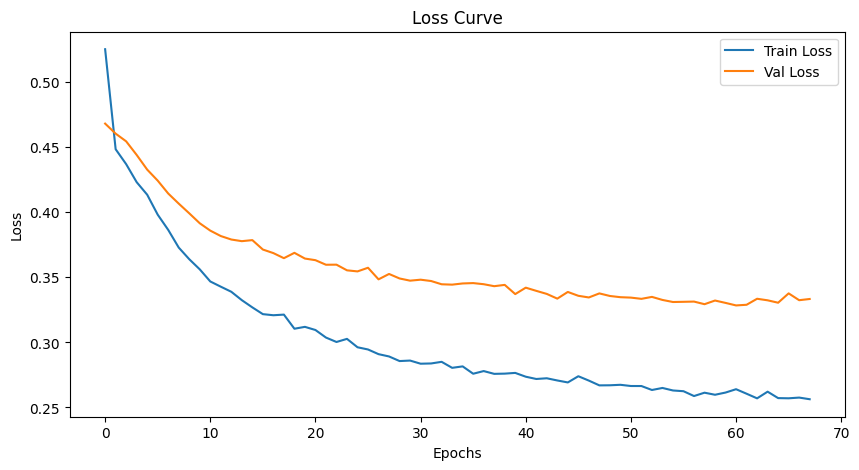

In [47]:
# Plot loss curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()


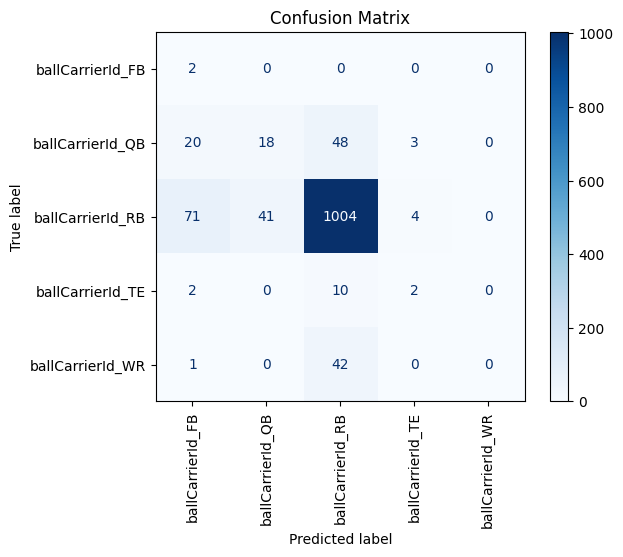

Validation Accuracy: 0.9324921135646688


In [48]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluation
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for data in val_loader:
        out = model(data)
        pred = torch.sigmoid(out) >= 0.5  # Apply sigmoid and threshold at 0.5
        all_preds.append(pred.cpu().numpy())
        all_targets.append(data.y.view_as(pred).cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Compute confusion matrix for all classes combined
cm = confusion_matrix(all_targets.argmax(axis=1), all_preds.argmax(axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_df.columns)
cm_display.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

accuracy = np.mean(all_preds == all_targets)
print(f'Validation Accuracy: {accuracy}')